---

# **Análise Exploratória de Dados de Logística**

# 1\. Contexto

Projeto de Data Wrangling completo de informações logísticas da Startup Loggi, geração de visualizações gráficas e retirada de insights operacionais do Distrito Federal, considerando uma variação alta na densidade demográfica das 3 regiões atendidas. Também, objetivando responder às 3 principais questões:

Questão 1: A quantidade de HUB's de distribuição está subdimensionada?

Questão 2: A distribuição de entregas por HUB está equilibrada?

Questão 3: E o que pode ser melhorado?

# 2\. Pacotes e bibliotecas

In [ ]:
# Instalando e importando todas as bibliotecas utilizadas no projeto

import json

import numpy as np
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


# 3\. Exploração de dados

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json


##3.1 Carregamento dos Dados
As informações de entregas logísticas estão disponíveis em um arquivo .json, logo, precisamos extrair as informações e transformar em um DataFrame do pandas para manipular mais facilmente os dados.

In [ ]:
# Extraindo as informações de entregas de um arquivo json e carregando em um dict python
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Transformando o dict python em um DataFrame do pandas
deliveries_df = pd.DataFrame(data)

# Visualizando o DataFrame deliveries_df
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


##3.2 Data Wrangling
Como pôde-se observar, há dados aninhados nas colunas "origin", então precisamos utilizar o método "json_normalize" do pandas para separar essas informações em colunas de um novo DataFrame.

In [ ]:
# Normalizando a coluna origin (gera um novo dataframe com as informações da coluna "origin" separadas em colunas)
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145
...,...,...
194,-47.893662,-15.805118
195,-47.802665,-15.657014
196,-47.893662,-15.805118
197,-48.054989,-15.838145


Como o novo DataFrame gerado, podemos mesclar ao DataFrame original pelo index e então excluir a coluna "origin" original.

In [ ]:
# Mesclando os DataFrames com o método merge do pandas por um inner join através dos index
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

# Excluindo a coluna "origin" original
deliveries_df = deliveries_df.drop("origin", axis=1)

# Selecionando e renomeando as novas colunas do DataFrame
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df


,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
...,...,...,...,...,...,...
194,cvrp-1-df-59,df-1,-47.893662,-15.805118,180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p..."
195,cvrp-0-df-87,df-0,-47.802665,-15.657014,180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p..."
196,cvrp-1-df-83,df-1,-47.893662,-15.805118,180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po..."
197,cvrp-2-df-7,df-2,-48.054989,-15.838145,180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p..."


Ainda há dados aninhados em diferentes níveis na coluna "deliveries", nesse caso, utilizaremos o método "explode" que gera, para cada registro, uma nova linha mantendo o indice original, após isso, separar as informações em colunas e dataframes novos.

In [ ]:
# Aplicando o método "explode" à coluna "deliveries"
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."
...,...
198,"{'id': '21693bf442ac5890adbdf2648c12881a', 'po..."
198,"{'id': '7aaa35088b37b6e542c4cd69663a7ebf', 'po..."
198,"{'id': '60c00d5390da4f28167439cd9c566703', 'po..."
198,"{'id': '51f456963785e7381243ff7baf7efd06', 'po..."


In [ ]:
# Criando um DataFrame diferente com uma coluna de cada informação e concatenando em um único DataFrame
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["id"])).rename(columns={"deliveries":"delivery_id"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_normalized_df

,delivery_size,delivery_id,delivery_lng,delivery_lat
0,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929
0,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772
0,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871
0,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471
0,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055
...,...,...,...,...
198,8,21693bf442ac5890adbdf2648c12881a,-48.064269,-15.997694
198,4,7aaa35088b37b6e542c4cd69663a7ebf,-48.065176,-16.003597
198,9,60c00d5390da4f28167439cd9c566703,-48.065841,-16.003808
198,1,51f456963785e7381243ff7baf7efd06,-48.062327,-16.001568


In [ ]:
# Excluindo a coluna "deliveries" original
deliveries_df = deliveries_df.drop("deliveries", axis=1)

# Mesclando o novo DataFrame deliveries_normalized_df com o DataFrame original deliveries_df, right join pelo index
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_id,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055
...,...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,8,21693bf442ac5890adbdf2648c12881a,-48.064269,-15.997694
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,4,7aaa35088b37b6e542c4cd69663a7ebf,-48.065176,-16.003597
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,9,60c00d5390da4f28167439cd9c566703,-48.065841,-16.003808
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,1,51f456963785e7381243ff7baf7efd06,-48.062327,-16.001568


##3.3 Análise Exploratória
Agora, com os dados estruturados em um DataFrame devidamente, partiremos para análise exploratória e limpeza dos dados.

In [ ]:
# Ver as dimensões do DF
deliveries_df.shape

(636149, 9)

In [ ]:
# Conhecer os tipos de dados e as colunas.
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_id       636149 non-null  object 
 7   delivery_lng      636149 non-null  float64
 8   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 43.7+ MB


In [ ]:
# Identificar valores nulos
deliveries_df.isna().sum()

name                0
region              0
hub_lng             0
hub_lat             0
vehicle_capacity    0
delivery_size       0
delivery_id         0
delivery_lng        0
delivery_lat        0
dtype: int64

In [ ]:
# Contar valores distintos nas colunas.
deliveries_df.nunique()

name                   199
region                   3
hub_lng                  3
hub_lat                  3
vehicle_capacity         1
delivery_size           10
delivery_id         291566
delivery_lng        291566
delivery_lat        291566
dtype: int64

In [ ]:
# Separar os dados numéricos dos dados categóricos
var_numericos = []
var_categoricas = []

for coluna in deliveries_df.columns:
  if deliveries_df[coluna].dtype != "object":
    var_numericos.append(coluna)
  else:
    var_categoricas.append(coluna)

print(f'As colunas numéricas são: {var_numericos}')
print(f'As colunas categóricas são: {var_categoricas}')


As colunas numéricas são: ['hub_lng', 'hub_lat', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']
As colunas categóricas são: ['name', 'region', 'delivery_id']


In [ ]:
# Ver um resumo estatístico dos dados numéricos.
deliveries_df[var_numericos].describe().T


,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


Observações:

1: Observa-se que os dados da coluna "vehicle_capacity" não apresentam variação, todos os valores são iguais a "180". Observação

 2: Os valroes da coluna "delivery_size" mostram que os volumes variam moderadamente, com uma média de 5.5121 e uma mediana de 6.0000, logo, desvio padrão de 2.8746, considerando a baixa amplitude, são variações relativamente moderadas.

# 4\. Manipulação

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [ ]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.0533433333333333,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-127, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state

In [ ]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")

deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


## 4.1 Verificando a qualidade

Qualidade do dados está relacionado a consistência do seu schema, valores faltantes, etc.

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [ ]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [ ]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

Uma boa parcela dos nomes dos bairros está faltante, cerca de 1/4

In [ ]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

É possivel notar que Brasilia é a cidade onde tem mais entregas e tem 3x mais entregas que a segunda colocada Taguatinga

In [ ]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

# 5\. Visualização

##5.1 Gráfico de entregas por região

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={"proportion": "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-29-1649afbc4b6d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
<ipython-input-29-1649afbc4b6d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")


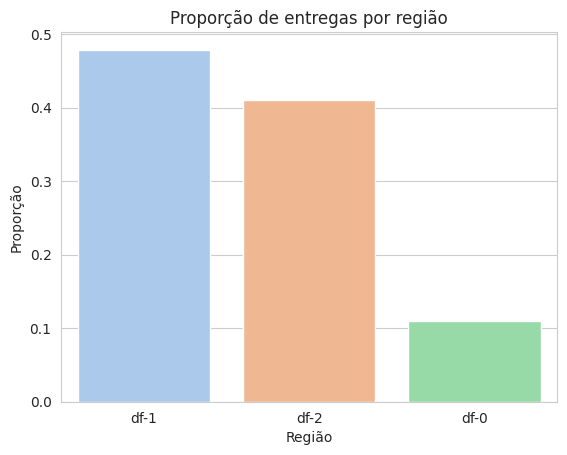

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

##5.2 Mapa dos Hubs

In [ ]:
# importo e processo os dados de geolocalização do Ditrito federal.

!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

mapa = gpd.read_file("distrito-federal.shp")

In [ ]:
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
# Criando o DataFrame com a localização dos hubs geo_hub_df

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = gpd.GeoDataFrame(hub_df, geometry=gpd.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [ ]:
# Criando o DataFrame com a localização dos deliveries geo_deliveries_df

geo_deliveries_df = gpd.GeoDataFrame(deliveries_df, geometry=gpd.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


<ipython-input-34-44de6b1fad48>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


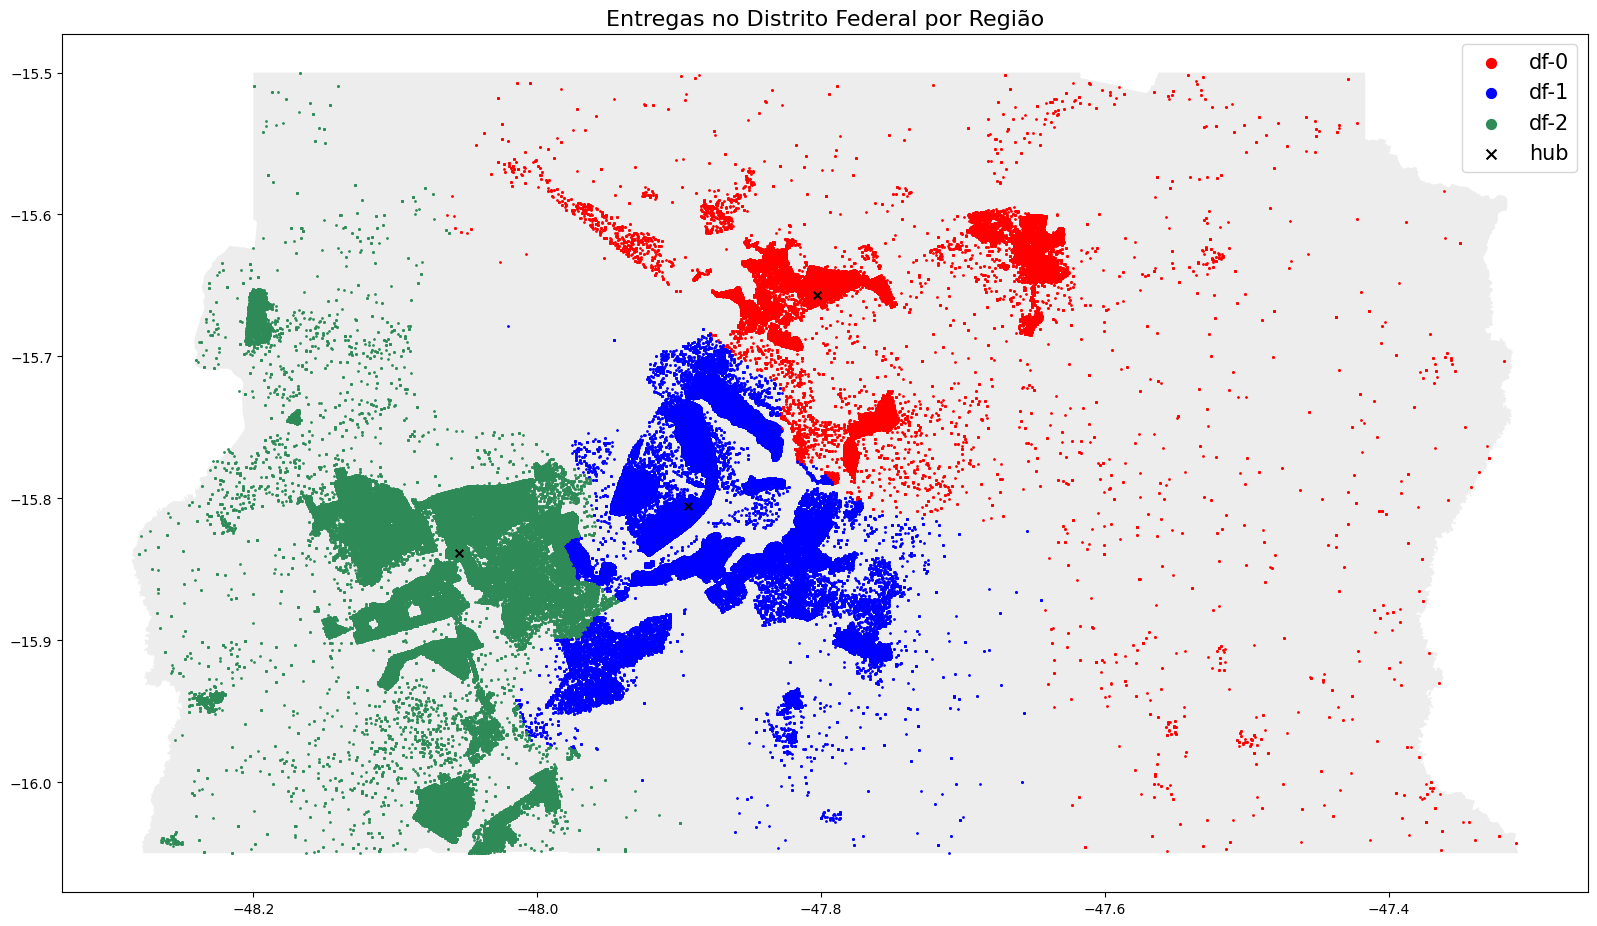

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

É possívle notar que Hubs tem áreas de atuação bem desproporcionais:



*   O hub **df-0** tem uma área de atuação grande com entegras bem espaçadas perto do hub tem o que parecer uma boa concentração das entregas e algumas regiões adjacentes também existe uma certa concentração. Mas nas demais espaços de atuação não apresente nenhum tipo de padrão ou área de aglomeração de entregas

*   O hub **df-1** é o que apresenta maior concentração de entregas com algumas poucas se misturando com a área de atuação do hub df-0

*   O hub **df-2** aprenseta um nível alto de concentração das entregas, com algumas áreas de interesse adjacentes, nas quais as entregas mais espaçadas ficam na extamente entre o hub essas outras áreas um pouco mais afastadas, o que facilita muito na lostiga de entregas.



--

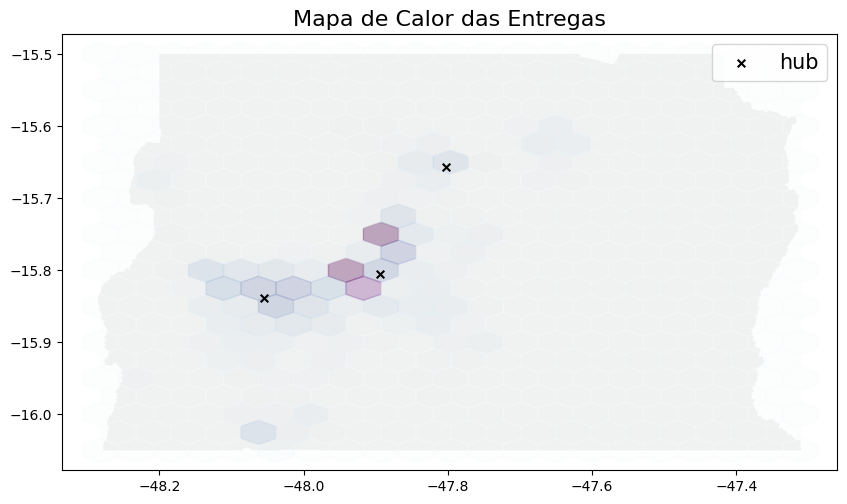

In [ ]:

# cria o plot vazio
fig, ax = plt.subplots(figsize=(10, 8))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas como mapa de calor
ax.hexbin(geo_deliveries_df['delivery_lng'], geo_deliveries_df['delivery_lat'], gridsize=20, cmap='BuPu', alpha=0.3)

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Mapa de Calor das Entregas", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for line in lgnd.get_lines():
    line.set_markersize(10)

plt.show()

Utilizando o mapa de calor é possívle ver uma zona bem defina onde são feitas as maioras das entregas. Essa é região bem localizada, tendo dois hubs dentro dela(df-1 e df-2) o que facilita muito para entregas mais ageis.

Uma possível otimização a ser feita e transferir o hub **df-0** para mais a noroeste, tendo em vista a discentralização das entregas feitas por esse hub. O que pode resultar em viagens mais curtas.

Enquanto focar em oferecer benefícios a faixa onde acontece a maioria das entregas: É possível ter prazos mais curtos e fretes mais baratos para essa região, pois ela conta com 2 hubs de entrega em seu interior.

